# Классификация извержения вулкана с помощью библиотеки Scikit-learn

# 1. Постановка задачи
Необходимо по снимкам с веб-камеры определять происходит в данный момент извержение вулкана или нет. 



# 2. Data Understanding

Набор данных - фотографии вуканов, разделенные на два класса:

'**alert**' (0) -  на фото зафиксирована любая активность на вулкане: парогазовый столб, взрыв, потоки лавы, 

'**normal**' (1) - нормальное состояние, никакой активности вулкана не отмечается, либо видимость не позволяет определить более точно. 



### 2.1 Import Libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Common libraries
import os
import random
from glob import glob
from imutils import paths

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
#from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, recall_score

# Visualisation
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
#sns.set_style('white')
#pylab.rcParams['figure.figsize'] = 8 , 6
plt.rcParams["axes.grid"] = False

### 2.2 Вспомогательные функции

In [8]:
IMG_SIZE = (256, 256)

# Загрузка изображения и приведение к общему размеру 
def load_image(path, target_size=IMG_SIZE):
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, target_size)
    return image  

# Обработка изображения - размерность не меняется
def gradient_image(src):
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    ##laplacian = cv2.Laplacian(image,cv2.CV_64F)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)    
    image = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
    
    return image 

# Вычисляем угол и длину вектора градиента
def gradient_image_polar(src,ddepth = cv2.CV_32F, scale = 1, delta = 0 ):
    image = cv2.GaussianBlur(src, (3, 3), 0)
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    g, theta = cv2.cartToPolar(grad_x, grad_y)
    return g, theta


# Вывод заданного количества изображений из указанной папки
def show_images(imagePaths, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(imagePaths, 1):
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title('%s' % path.split('/')[-2])
      img = cv2.imread(path)[...,::-1]
      img = cv2.resize(img, IMG_SIZE)
      plt.imshow(img)

In [9]:
class ColorDescriptor:
    
    def __init__(self, bins):
        # количество сегментов по y, x и channel
        self.bins = bins
 
    def describe(self, image):
        """ Вычисляем дескриптор изображения """
        
        features = []  # результирующий вектор дескриптора
        
        # переводим исходное изображение из цветового пространства BGR в HSV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
        (h, w) = image.shape[:2]  # размеры изображения
        (cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения
        
        # делим изображение на четыре равные части
        # и вычисляем координаты сегментов
        segments = [(0, cX, 0, cY), 
                    (cX, w, 0, cY),
                    (cX, w, cY, h),
                    (0, cX, cY, h)]
 
        # готовим маску в виде эллипса для выделения 
        # дескрипторов центральной части изображения
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellip_mask = np.zeros(image.shape[:2], dtype = np.uint8)
        cv2.ellipse(ellip_mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
 
        # итерируем по четырем сегментам и вычисляем дескрипторы
        for (startX, endX, startY, endY) in segments:
            # формируем маску сегмента
            corner_mask = np.zeros(image.shape[:2], dtype = np.uint8)
            cv2.rectangle(corner_mask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(corner_mask, ellip_mask)  # вычитаем пересечение с эллипсом 
 
            # строим цветовую гистограмму с учетом маски сегмента
            hist = self.histogram(image, corner_mask)
            features.extend(hist)
 
        # вычисляем гистограму для центральной области
        hist = self.histogram(image, ellip_mask)
        features.extend(hist)
 
        # возвращаем вектор полученный вектор дескрипторов
        return features
    
    def histogram(self, image, mask):
        """ Вычисляет гистограмму в области, заданной маской """
        
        # задаем диапазоны изменений по каналам
        ranges = [0, 180,  # Hue
                  0, 256,  # Saturation
                  0, 256]  # Value
        
        # вычисляем 3D гистограмму (x, y, channel)
        hist = cv2.calcHist([image], [0, 1, 2], mask,
                            self.bins, ranges = ranges)
        
        # нормируем гистограмму
        hist = cv2.normalize(hist, np.zeros_like(hist)).flatten()

        return hist

### 2.3 Загрузка данных

Подготовим три датасета. 
Датасеты для обучения и вализации разбиты на классы. Класс соответствует названию папки.
Датасет дл теста не разбит по классам.

In [12]:
train = []
train_labels = []

validation = []
validation_labels = []
 
test = []

imagePaths_train = sorted(list(paths.list_images('/content/drive/MyDrive/ML/Volcano/train')))
for imagePath in imagePaths_train:
    image = load_image(imagePath)
    train.append(image)
    label = imagePath.split(os.path.sep)[-2]
    train_labels.append(label) 
    
imagePaths_validation = sorted(list(paths.list_images('/content/drive/MyDrive/ML/Volcano/test')))
for imagePath in imagePaths_validation:
    image = load_image(imagePath)
    validation.append(image)
    label = imagePath.split(os.path.sep)[-2]
    validation_labels.append(label)     

imagePaths_test = sorted(list(paths.list_images('/content/drive/MyDrive/ML/Volcano/img')))
for imagePath in imagePaths_test:
    image = load_image(imagePath)
    test.append(image)

# перемешиваем выборку для получения разных результатов при анализе данных
random.shuffle(imagePaths_train)
random.shuffle(imagePaths_validation)


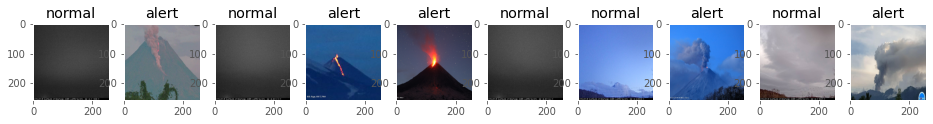

In [13]:
show_images(imagePaths_train[0:10], 1,  10)

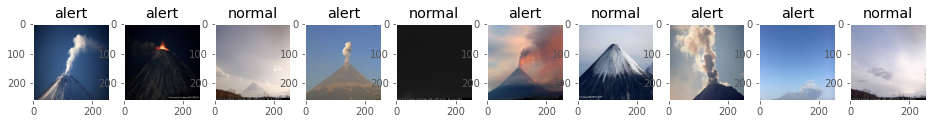

In [14]:
show_images(imagePaths_validation[0:10], 1,  10)

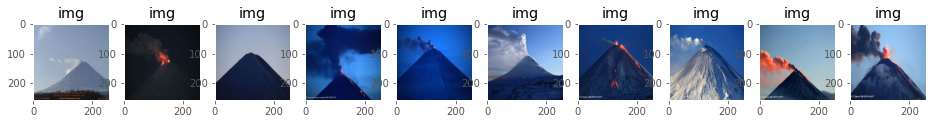

In [15]:
show_images(imagePaths_test[0:10], 1,  10)

### 2.4 Анализ данных

Для анализа данных пробуем использовать различные фильтры, переводим в различные цветовые схемы. 

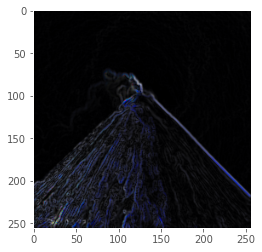

In [16]:
src = cv2.GaussianBlur(train[5], (3, 3), 0)
laplacian = cv2.Laplacian(src,cv2.CV_64F)
src = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)  
sobelx = cv2.Sobel(src,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(src,cv2.CV_64F,0,1,ksize=3)
abs_grad_x = cv2.convertScaleAbs(sobelx)
abs_grad_y = cv2.convertScaleAbs(sobely)
    
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
grad = cv2.cvtColor(grad, cv2.COLOR_HSV2BGR)  
plt.imshow(grad)

In [17]:
grad.shape

(256, 256, 3)

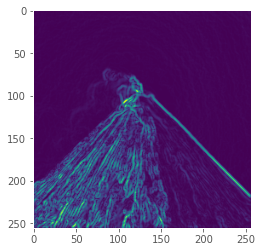

In [18]:
# второй вариант  сокращение размерности  за счет перевода cv2.COLOR_BGR2GRAY
scale = 1
delta = 0
#ddepth = cv2.CV_16S
ddepth = cv2.CV_32F
src = cv2.GaussianBlur(train[5], (3, 3), 0)
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)  
grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
    
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
#grad = cv2.cvtColor(grad, cv2.COLOR_HSV2BGR)  
plt.imshow(grad)

In [19]:
grad.shape

(256, 256)

Пробуем строить границы и контуры на изображении, используя метод Суперпиксель.

In [20]:
from cv2 import ximgproc

seeds = None
display_mode = 0
num_superpixels = 20
prior = 4
num_levels = 9
num_histogram_bins = 5
num_iterations = 1000

img = train[0]
# преобразуем пространство цветов
converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

height,width,channels = converted_img.shape

# инициализируем алгоритм
seeds = ximgproc.createSuperpixelSEEDS(width, height, channels,
            num_superpixels, num_levels, prior, num_histogram_bins)

# выполняем num_iterations шагов
seeds.iterate(converted_img, num_iterations)

# получаем разметку пикселей
labels = seeds.getLabels()

# получаем маску контуров
mask = seeds.getLabelContourMask(thick_line=False)

# инвертируем маску
mask_inv = cv2.bitwise_not(mask)

# зануляем пикселы исходной картинки на границах
result_bg = cv2.bitwise_and(img, img, mask=mask_inv)

# создаем изображение контуров
color_img = np.zeros((height,width,3), np.uint8)
color_img[:] = (0, 255, 0)
result_fg = cv2.bitwise_and(color_img, color_img, mask=mask)

# совмещаем границы с исходным изображением
result = cv2.add(result_bg, result_fg)

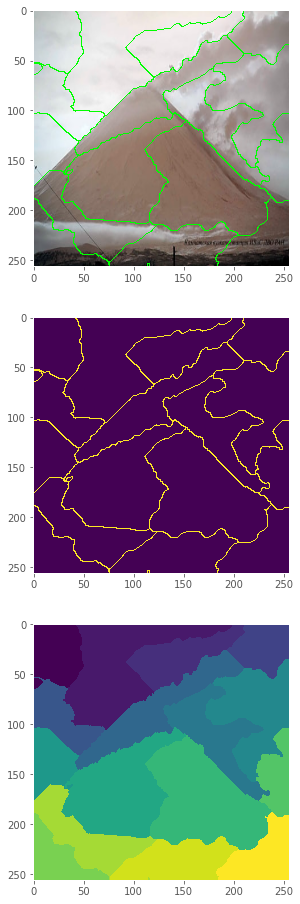

In [21]:
imgs = [cv2.cvtColor(result, cv2.COLOR_BGR2RGB),
        mask, labels]
fig = plt.figure(figsize=(10, 16))
for i, e in enumerate(imgs, 1):
    subplot = fig.add_subplot(3, 1, i)
    plt.imshow(e);

Попробуем опредлять маску изображения по алгоритму GrabCut

http://en.wikipedia.org/wiki/GrabCut


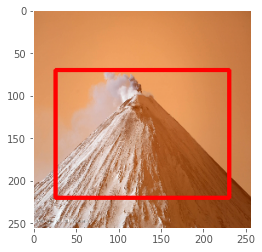

In [22]:
# прямоугльником задаем область принадлежащую объекту
RECT = (26,70,230,220)
img = train[5]

# визуализируем выделенную область
x1, y1, x2, y2 = RECT
tmp = cv2.rectangle(np.copy(img), (x1,y1), (x2,y2), (0,0,255), 3)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

# выделяем память под результат работы алгоритма
mask = np.zeros(img.shape[:2], np.uint8)

# выделяем память необходимую для работы алгоритма
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

cv2.grabCut(img, mask, RECT, bgdModel,
            fgdModel, 18, cv2.GC_INIT_WITH_RECT);

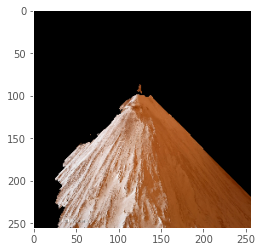

In [23]:
mask2 = np.where((mask==0)|(mask==2), 0, 1).astype('uint8')
result = img * mask2[:,:,np.newaxis]
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

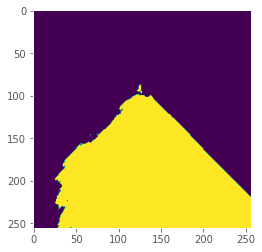

In [24]:
plt.imshow(mask2)

Посмотрим, как можно исползовать метод характерных точек. Вычислим для них дескрипторы, затем опредлим соответствия между шаблоном и сценой (двумя изображениями).

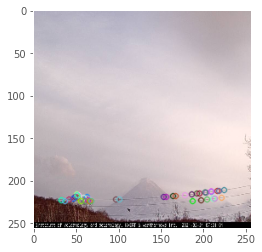

In [166]:
# инициализируем детектор точек
orb = cv2.ORB_create()
img = train[30]
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = orb.detectAndCompute(img, None)
img1_kp = cv2.drawKeypoints(img, kp1, np.zeros_like(img))
plt.imshow(img1_kp)


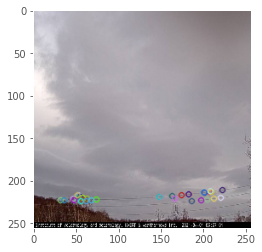

In [168]:
img_find = train[32]
kp2, des2 = orb.detectAndCompute(img_find, None)
img2_kp = cv2.drawKeypoints(img_find, kp2, np.zeros_like(img_find))
plt.imshow(img2_kp)

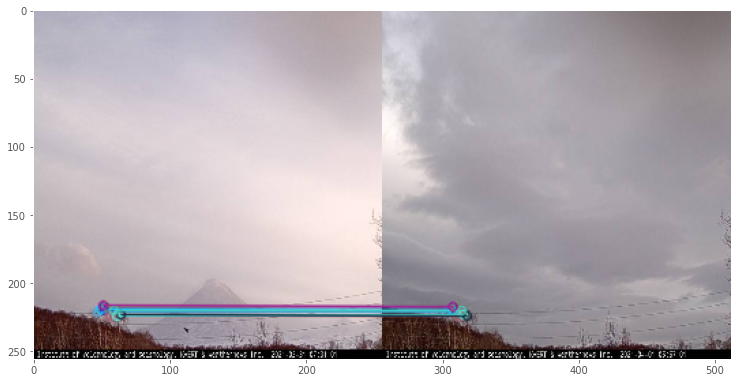

(<matplotlib.image.AxesImage at 0x7f8931d27a10>, None)

In [169]:
# матчинг полным перебором - brute force matching
# мера расстояния - расстояние Хэмминга (количество несовпадающих компонент)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# матчинг
matches = bf.match(des1, des2)

# сортируем результат по убыванию расстояния
matches = sorted(matches, key = lambda x: x.distance)

# выводим 10 лучших совпадений
img3 = np.zeros_like(img_find)
img3 = cv2.drawMatches(img, kp1, img_find, kp2, matches[:10], img3, flags=2)

fig = plt.gcf()
fig.set_size_inches(12.5, 8.5)
plt.imshow(img3),plt.show()

#  3.  Data Preparation

## 3.1 Feature Engineering

Рассчитаем несколько дескрипторов изображений



### Гистограмма изображения, постороенная с использованием фильтра Собеля

Вычисляем градиент и гистограммы для изображения. Для этого переводим градиент в полярные координаты, вычисляем гистограмму (используя угол и длину вектора градиента) и нормируем ее.

In [177]:
train_grad = np.zeros_like(train)
train_g = np.zeros_like(train).astype(float)
train_theta = np.zeros_like(train).astype(float)

for i in range(len(train)):  
    train_g[i], train_theta[i] = gradient_image_polar(train[i])  # длина вектора и угол 
    train_grad[i] = gradient_image(train[i])  # градиент


validation_grad = np.zeros_like(validation)
validation_g = np.zeros_like(validation).astype(float)
validation_theta = np.zeros_like(validation).astype(float)

for i in range(len(validation)):
    validation_g[i], validation_theta[i] = gradient_image_polar(validation[i]) 
    validation_grad[i] = gradient_image(validation[i])
    

test_grad = np.zeros_like(test)
test_g = np.zeros_like(test).astype(float)
test_theta = np.zeros_like(test).astype(float)

for i in range(len(test)):
    test_g[i], test_theta[i] = gradient_image_polar(test[i]) 
    test_grad[i] = gradient_image(test[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


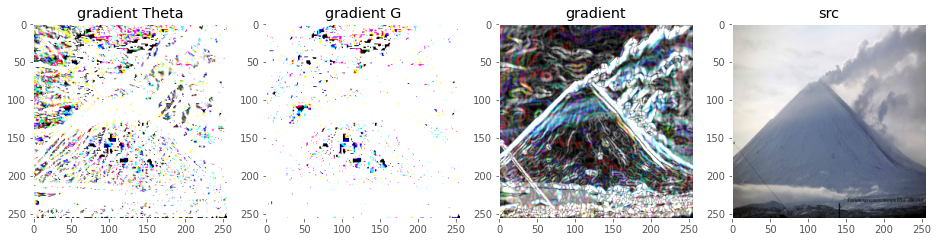

In [178]:
fig = plt.figure(figsize=(16, 8))
subplot = fig.add_subplot(1, 4, 1)
subplot.set_title('gradient Theta')
img = train_theta[0]
plt.imshow(img)
subplot = fig.add_subplot(1, 4, 2)
subplot.set_title('gradient G')
img = train_g[0]
plt.imshow(img)
subplot = fig.add_subplot(1, 4, 3)
subplot.set_title('gradient')
img = train_grad[0]
plt.imshow(img)
subplot = fig.add_subplot(1, 4, 4)
subplot.set_title('src') 
img = train[0]
plt.imshow(img)

In [179]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train), 64))
for i in range(len(train)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

validation_hist = np.zeros((len(validation), 64))
for i in range(len(validation)):
    hist, borders = np.histogram(validation_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=validation_g[i])
    validation_hist[i] = hist

test_hist = np.zeros((len(test), 64))
for i in range(len(test)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist
    
# По умолчанию используется L2 норма - нормируем вектор гистограмм
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
validation_hist = validation_hist / np.linalg.norm(validation_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [180]:
# проверяем размерность
print(len(train_hist), "train obs. descriptor shape: ", len(train_hist[0]))
print(len(validation_hist), "validation obs. descriptor shape: ", len(validation_hist[0]))
print(len(test_hist),"test obs. descriptor shape: ", len(test_hist[0]) )
test_hist[0]

65 train obs. descriptor shape:  64
22 validation obs. descriptor shape:  64
25 test obs. descriptor shape:  64


array([0.11735462, 0.05013934, 0.05884957, 0.05700774, 0.0596333 ,
       0.05265203, 0.04402444, 0.10808421, 0.02955859, 0.05017538,
       0.06072872, 0.07305742, 0.07846953, 0.07157918, 0.09325299,
       0.08972363, 0.1861923 , 0.08928284, 0.08694144, 0.0822214 ,
       0.08862404, 0.0756144 , 0.05655787, 0.03263022, 0.14830829,
       0.05103865, 0.06633935, 0.08781679, 0.07303179, 0.06992283,
       0.05436589, 0.0362965 , 0.16062645, 0.05337189, 0.07111131,
       0.08259025, 0.09545951, 0.09804124, 0.10618587, 0.22282452,
       0.16971691, 0.17328144, 0.2075822 , 0.22140296, 0.21909394,
       0.23560663, 0.23391831, 0.21681397, 0.30963697, 0.19348056,
       0.17068407, 0.16154273, 0.12646911, 0.13989133, 0.1731681 ,
       0.15609687, 0.13476771, 0.0603183 , 0.05588345, 0.05315421,
       0.04772047, 0.05072419, 0.0462091 , 0.03252657])

### Цветовая гистограмма 5 блоков

Дескриптор, построенный на основе цветовой гистограммы для 5 частей изображения:  4 квадранта и центральный эллипс 

In [181]:
cd = ColorDescriptor((256, 256, 3))

train_histogram = []

for i in range(len(train)):
    train_histogram.append(cd.describe(train[i]))
    
validation_histogram = []

for i in range(len(validation)):
    validation_histogram.append(cd.describe(validation[i]))

test_histogram = []

for i in range(len(test)):
    test_histogram.append(cd.describe(test[i]))

print(len(train_histogram), "train obs. descriptor shape: ", len(train_histogram[0]))
print(len(validation_histogram), "validation obs. descriptor shape: ", len(validation_histogram[0]))
print(len(test_histogram),"test obs. descriptor shape: ", len(test_histogram[0]) )

65 train obs. descriptor shape:  983040
22 validation obs. descriptor shape:  983040
25 test obs. descriptor shape:  983040


### Дескриптор HOGD

In [33]:
# задаем размерность дескриптора
hog = cv2.HOGDescriptor()  
img = cv2.resize(train_grad[0], (128,128))
h = hog.compute(np.uint8(img))
print('Descriptor size: %d' % len(h))

Descriptor size: 34020


In [182]:
train_descriptor = np.zeros((len(train_grad), 34020))
for i in range(len(train_grad)):
    img = cv2.resize(train_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    train_descriptor[i] = h.reshape(-1)
    
validation_descriptor = np.zeros((len(validation_grad), 34020))
for i in range(len(validation_grad)):
    img = cv2.resize(validation_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    validation_descriptor[i] = h.reshape(-1)
    
test_descriptor = np.zeros((len(test_grad), 34020))
for i in range(len(test_grad)):
    img = cv2.resize(test_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    test_descriptor[i] = h.reshape(-1)

In [183]:
# проверяем размерность 
print(len(train_descriptor[0]), "train  descriptor shape: ", len(train_descriptor.shape))
print(len(validation_descriptor[0]), "validation  descriptor shape: ", len(validation_descriptor.shape))
print(len(test_descriptor[0]),"test  descriptor shape: ", len(test_descriptor.shape))

34020 train  descriptor shape:  2
34020 validation  descriptor shape:  2
34020 test  descriptor shape:  2


## 3.2 Создание датасетов для классификации

Для классификации соединим полученные на предыдущем этапе признаки в общий датасет.


In [184]:
# проверяем размерность
print('Обучающая выборка X ', len(train))
print('Обучающая выборка Y ', len(train_labels))
print('массив градиентов   ', train_grad.shape)
print('длины векторов      ', train_g.shape)
print('угол                ', train_theta.shape)

print('HOGD дескриптор     ', train_descriptor.shape)
print('дескриптор Собеля   ', train_hist.shape)
print('5 блочный дескриптор', len(train_histogram[0]))


Обучающая выборка X  65
Обучающая выборка Y  65
массив градиентов    (65, 256, 256, 3)
длины векторов       (65, 256, 256, 3)
угол                 (65, 256, 256, 3)
HOGD дескриптор      (65, 34020)
дескриптор Собеля    (65, 64)
5 блочный дескриптор 983040


In [185]:
train_descriptor

array([[0.13941099, 0.23537295, 0.22995636, ..., 0.16211377, 0.10623142,
        0.09925929],
       [0.07830389, 0.2171821 , 0.23250711, ..., 0.1835821 , 0.13097927,
        0.21902917],
       [0.04269775, 0.06798034, 0.14321172, ..., 0.23714277, 0.19651921,
        0.12637526],
       ...,
       [0.16019149, 0.24546681, 0.21073072, ..., 0.1365643 , 0.05170273,
        0.05362931],
       [0.14696382, 0.2486698 , 0.24890843, ..., 0.24026437, 0.06082585,
        0.07889795],
       [0.21094343, 0.26577327, 0.26577327, ..., 0.22001645, 0.15138106,
        0.06142072]])

In [186]:
train_hist

array([[0.08603311, 0.03946726, 0.04567764, ..., 0.04788946, 0.04135009,
        0.03117585],
       [0.19882042, 0.06997772, 0.08154101, ..., 0.08754786, 0.07300243,
        0.05062779],
       [0.18455759, 0.07986572, 0.06726256, ..., 0.10117695, 0.08376876,
        0.07061676],
       ...,
       [0.22882811, 0.08651914, 0.09614254, ..., 0.08625116, 0.08840292,
        0.05876273],
       [0.16624461, 0.08648199, 0.11996049, ..., 0.09460573, 0.07580021,
        0.06525086],
       [0.16367614, 0.05998509, 0.04635621, ..., 0.07101152, 0.06239276,
        0.05402727]])

In [187]:
x_train = np.hstack((train_descriptor,train_hist))
x_val = np.hstack((validation_descriptor,validation_hist))
x_test = np.hstack((test_descriptor,test_hist))
x_test.shape

(25, 34084)

Итоговый датасет для обучения модели:

In [188]:
x_train = np.hstack((x_train,train_histogram))
x_val = np.hstack((x_val,validation_histogram))
x_test = np.hstack((x_test,test_histogram))
x_train.shape

(65, 1017124)

In [75]:
y_train = train_labels
y_val = validation_labels


# 4. Modeling 

Для решения бинарной классификации изображений воспользуемся библиотекой Scikit-learn.




## 4.1 Классификаторы
Логистическая регрессия

In [79]:
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)   

y_predict_lr = lr_clf.predict(x_val)
y_predict_test_lr = lr_clf.predict(x_test)

recall_average_lr = recall_score(y_val, y_predict_lr, average="binary", pos_label='normal') 

print('Accuracy: %s' % accuracy_score(y_val, y_predict_lr))
print('Recall: %s' % recall_average_lr)
print(classification_report(y_val, y_predict_lr))

Accuracy: 0.8636363636363636
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.90      0.82      0.86        11
      normal       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22



Деревья решений

In [80]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)   

y_predict_dt = dt_clf.predict(x_val)
y_predict_test_dt = dt_clf.predict(x_test)

recall_average_dt = recall_score(y_val, y_predict_dt, average="binary", pos_label='normal') 

print('Accuracy: %s' % accuracy_score(y_val, y_predict_dt))
print('Recall: %s' % recall_average_dt)
print(classification_report(y_val, y_predict_dt))

Accuracy: 0.7272727272727273
Recall: 0.8181818181818182
              precision    recall  f1-score   support

       alert       0.78      0.64      0.70        11
      normal       0.69      0.82      0.75        11

    accuracy                           0.73        22
   macro avg       0.74      0.73      0.73        22
weighted avg       0.74      0.73      0.73        22



RandomForestClassifier

In [191]:
clf_rf = RandomForestClassifier(n_estimators=30, max_depth=4,   n_jobs=-1)
clf_rf.fit(x_train, y_train)   
y_predict_rf = clf_rf.predict(x_val)
y_predict_test_rf = clf_rf.predict(x_test)

recall_average_rf = recall_score(y_val, y_predict_rf, average="binary", pos_label='normal') 

print('Accuracy: %s' % accuracy_score(y_val, y_predict_rf))
print('Recall: %s' % recall_average_rf)
print(classification_report(y_val, y_predict_rf))

Accuracy: 0.8181818181818182
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.89      0.73      0.80        11
      normal       0.77      0.91      0.83        11

    accuracy                           0.82        22
   macro avg       0.83      0.82      0.82        22
weighted avg       0.83      0.82      0.82        22



BaggingClassifier

In [77]:
bg_clf = BaggingClassifier(n_estimators=50, n_jobs=-1)
bg_clf.fit(x_train, y_train)   

y_predict_bg = bg_clf.predict(x_val)
y_predict_test_bg = bg_clf.predict(x_test)

recall_average_bg = recall_score(y_val, y_predict_bg, average="binary", pos_label='normal') 

print('Accuracy: %s' % accuracy_score(y_val, y_predict_bg))
print('Recall: %s' % recall_average_bg)
print(classification_report(y_val, y_predict_bg))

Accuracy: 0.8636363636363636
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.90      0.82      0.86        11
      normal       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22



GradientBoostingClassifier

In [78]:
gb_clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5)
gb_clf.fit(x_train, y_train)   

y_predict_gb = gb_clf.predict(x_val)
y_predict_test_gb = gb_clf.predict(x_test)

recall_average_gb = recall_score(y_val, y_predict_gb, average="binary", pos_label='normal') 

print('Accuracy: %s' % accuracy_score(y_val, y_predict_gb))
print('Recall: %s' % recall_average_gb)
print(classification_report(y_val, y_predict_gb))

Accuracy: 0.7727272727272727
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.88      0.64      0.74        11
      normal       0.71      0.91      0.80        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22



## 4.2 Результаты классификации для тестовой выборки

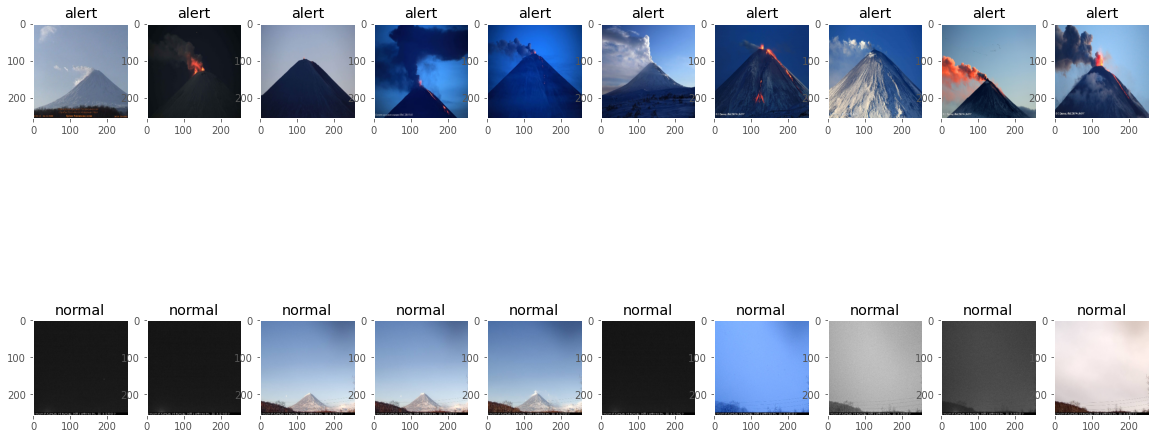

In [84]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test_lr[i - 1]);

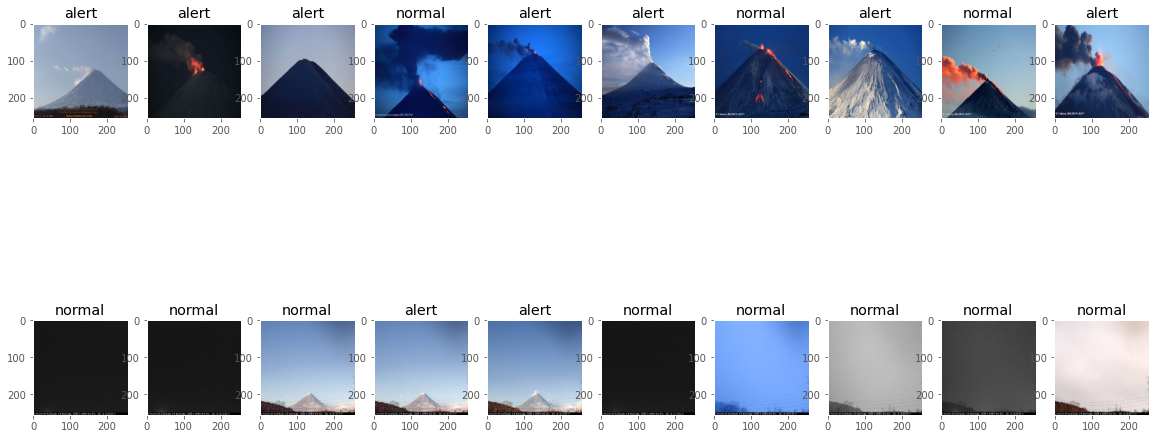

In [85]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test_dt[i - 1]);

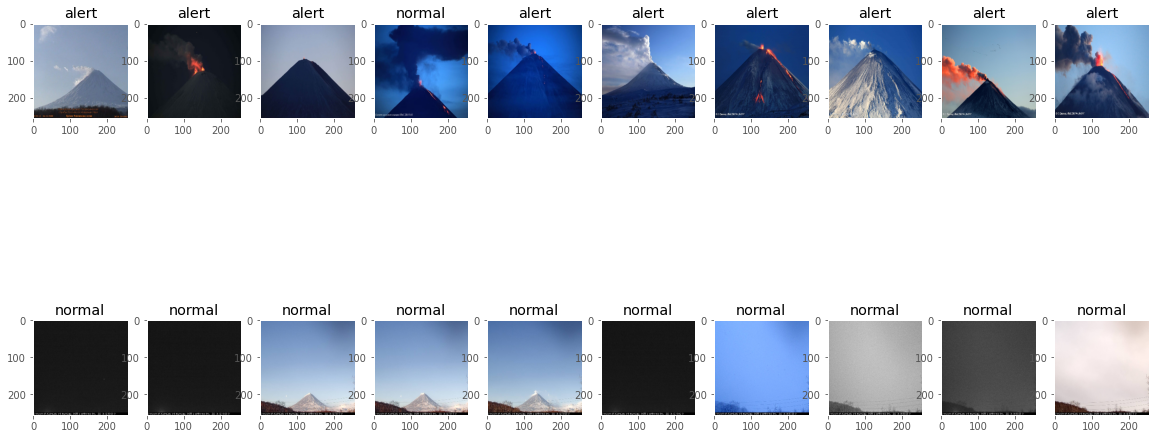

In [192]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test_rf[i - 1]);

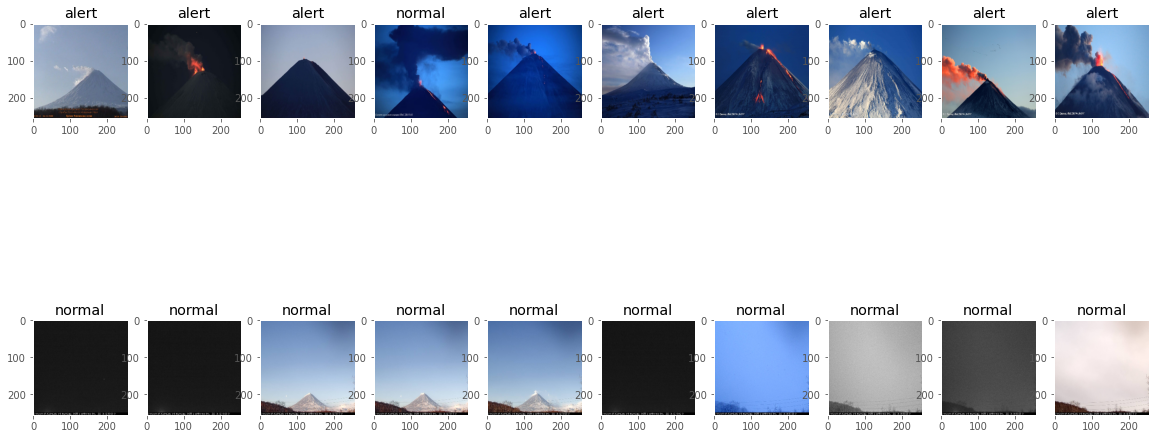

In [82]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test_bg[i - 1]);

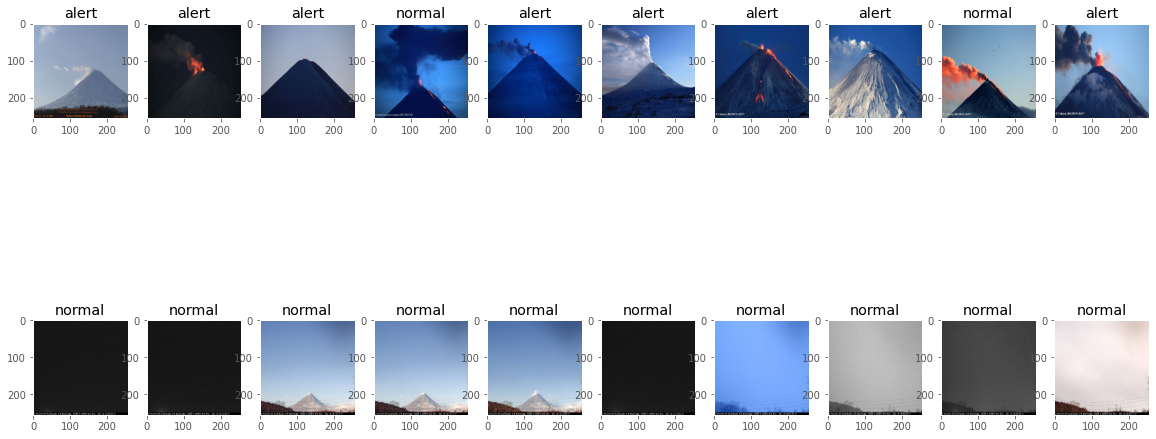

In [83]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test_gb[i - 1]);

# Deployment

Обработка входного изображения и выдача резульата:

In [120]:
image = load_image('img.jpg')


test_grad = np.zeros_like(image)
test_g = np.zeros_like(image).astype(float)
test_theta = np.zeros_like(image).astype(float)

test_g, test_theta = gradient_image_polar(image) 
test_grad = gradient_image(image)

test_hist = np.zeros(64)
test_hist, borders = np.histogram(test_theta,
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=test_g)


test_hist = test_hist / np.linalg.norm(test_hist)

test_histogram = []
test_histogram = cd.describe(image)

test_descriptor = np.zeros(34020)
img = cv2.resize(test_grad, (128,128))
h = hog.compute(np.uint8(img))
test_descriptor = h.reshape(-1)


x_test = np.append(test_descriptor,test_hist, axis = 0)

x_test = np.append(x_test, test_histogram, axis = 0).reshape(1, -1)

y_predict_test_rf = clf_rf.predict(x_test)
y_predict_test_bg = bg_clf.predict(x_test)
y_predict_test_gb = gb_clf.predict(x_test)
y_predict_test_lr = lr_clf.predict(x_test)
y_predict_test_dt = dt_clf.predict(x_test)

Predictions:
['normal']  - RandomForest
['normal']  - Bagging
['normal']  - GradientBoosting
['normal']  - LogisticRegression
['normal']  - DecisionTree


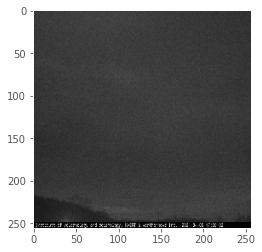

In [124]:
plt.imshow(image, cmap='gray');
print('Predictions:')
print(y_predict_test_rf,' - RandomForest')
print(y_predict_test_bg,' - Bagging')
print(y_predict_test_gb,' - GradientBoosting')
print(y_predict_test_lr,' - LogisticRegression')
print(y_predict_test_dt,' - DecisionTree')

Для массива фото:

In [193]:
images = []
#imagePaths = sorted(list(paths.list_images('/content/*.jpg')))
imagePaths = ['img2.jpg','img.jpg']
for imagePath in imagePaths:
    image = load_image(imagePath)
    images.append(image)


images_grad = np.zeros_like(images)
images_g = np.zeros_like(images).astype(float)
images_theta = np.zeros_like(images).astype(float)

for i in range(len(images)):
    images_g[i], images_theta[i] = gradient_image_polar(images[i])  
    images_grad[i] = gradient_image(images[i])

images_hist = np.zeros((len(images), 64))
for i in range(len(images)):
    hist, borders = np.histogram(images_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=images_g[i])

    images_hist[i] = hist

images_hist = images_hist / np.linalg.norm(images_hist, axis=1)[:, None]

images_histogram = []

for i in range(len(images)):
    images_histogram.append(cd.describe(images[i]))

images_descriptor = np.zeros((len(images_grad), 34020))
for i in range(len(images_grad)):
    img = cv2.resize(images_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    images_descriptor[i] = h.reshape(-1)

x_test = np.hstack((images_descriptor, images_hist))

x_test = np.hstack((x_test,images_histogram))

y_predict_test_rf = clf_rf.predict(x_test)
y_predict_test_bg = bg_clf.predict(x_test)
y_predict_test_gb = gb_clf.predict(x_test)
y_predict_test_lr = lr_clf.predict(x_test)
y_predict_test_dt = dt_clf.predict(x_test)

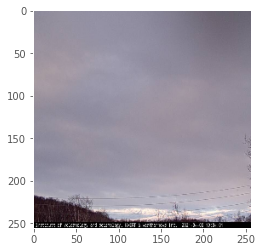

Predictions:
normal  - RandomForest
normal  - Bagging
normal  - GradientBoosting
normal  - LogisticRegression
normal  - DecisionTree


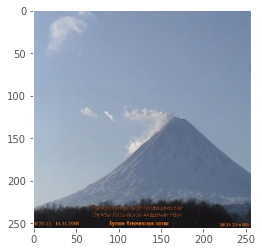

Predictions:
alert  - RandomForest
alert  - Bagging
alert  - GradientBoosting
alert  - LogisticRegression
alert  - DecisionTree


In [194]:
 for i in range(len(images)): 
  plt.imshow(images[i], cmap='gray');
  plt.show()
  print('Predictions:')
  print(y_predict_test_rf[i],' - RandomForest')
  print(y_predict_test_bg[i],' - Bagging')
  print(y_predict_test_gb[i],' - GradientBoosting')
  print(y_predict_test_lr[i],' - LogisticRegression')
  print(y_predict_test_dt[i],' - DecisionTree')


# TODO:



* сравнить точность по ЧБ и по цветному изображению 
* подбор параметров с использованием GridSV
* график recall_average,  accuracy